In [250]:
%matplotlib inline

#You need the following modues, if you don't have them, use pip install <module-name>
import requests
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import dates
import matplotlib.dates as mdates


In [306]:
# Implicit Grant Flow
#Enter your OAuth token in place
#supposed to expire in 2021-03-27 - 12:40 PM - [GMT + 5:30 time zone]

access_token = "OAuth Token"

day_range_length = 15

start_date = str((datetime.datetime.now() - datetime.timedelta(days=day_range_length)).date())
#start_date = "2021-03-19"

end_date = str(datetime.datetime.date(datetime.datetime.now())) 
#end_date = "2021-04-02"


<h2>HR analysis</h2>

In [263]:
import datetime

#Update your start and end dates here in yyyy-mm-dd format 
start = datetime.datetime.strptime(start_date, "%Y-%m-%d")
end = datetime.datetime.strptime(end_date, "%Y-%m-%d")

date_array = (start + datetime.timedelta(days=x) for x in range(0, (end-start).days))

day_list = []
for date_object in date_array:
    day_list.append(date_object.strftime("%Y-%m-%d"))
    
print("day range : ",day_list)

day range :  ['2021-03-19', '2021-03-20', '2021-03-21', '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25', '2021-03-26', '2021-03-27', '2021-03-28', '2021-03-29', '2021-03-30', '2021-03-31', '2021-04-01', '2021-04-02']


In [264]:
df_all = pd.DataFrame()

In [265]:


header = {'Authorization': 'Bearer {}'.format(access_token)}

for single_day in day_list:
    response = requests.get("https://api.fitbit.com/1/user/-/activities/heart/date/"+ single_day +"/1d/1min/time/00:00/23:59.json", headers=header).json()
    try:
        df = pd.DataFrame(response['activities-heart-intraday']['dataset'])
        date = pd.Timestamp(single_day).strftime('%Y-%m-%d')
        df = df.set_index(pd.to_datetime(date + ' ' + df['time'].astype(str)))
        #print(df)
        df_all = df_all.append(df, sort=True)
    except KeyError as e:
        print("No data for the given date", date)
    
#df_all.index.set_names('dateTime', inplace = True)   
del df_all['time']

In [266]:
#Put the interval you want to take the average of the imported data from fitbit with 2-5 sec interval. Default 10 minute
summary_df = (df_all['value'].resample('10Min').mean())

<AxesSubplot:xlabel='time'>

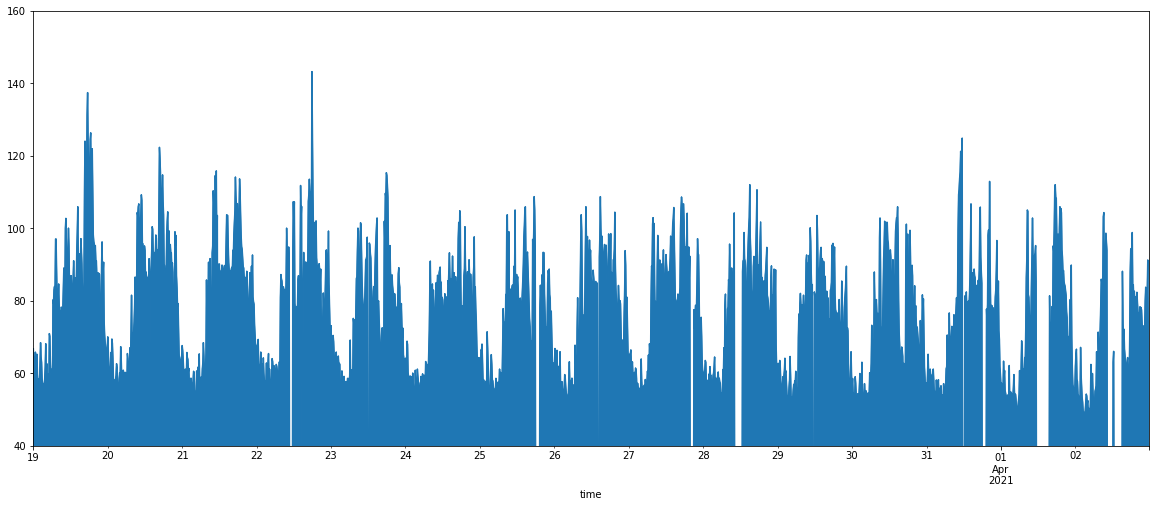

In [267]:
plt.rcParams["figure.figsize"]=20,8

# Heart rate data summary [10min avg] from start date[2021-03-18] to end date[2021-03-21] 
#if you are using matplotlib directly in python ( py file ) then use plt.plot(summary_df,kind='area')
summary_df.plot.area(ylim=(40,160))

<h2>Sleep analysis</h2>

In [268]:
header = {'Authorization': 'Bearer {}'.format(access_token)}

response = requests.get("https://api.fitbit.com/1.2/user/-/sleep/date/"+start_date+"/"+end_date+".json", headers=header).json()

In [269]:
combined_list = []
for i in range(len(response['sleep'])):
    result = response['sleep'][i]['levels']['summary']
    try:
        nice_dict = {'day':response['sleep'][i]['dateOfSleep'], 'deep_minutes':response['sleep'][i]['levels']['summary']['deep']['minutes'], 'light_minutes':response['sleep'][i]['levels']['summary']['light']['minutes'], 'rem_minutes':response['sleep'][i]['levels']['summary']['rem']['minutes'], 'wake_minutes':response['sleep'][i]['levels']['summary']['wake']['minutes']}
        combined_list.append(nice_dict)
    except:
        pass

In [270]:
sleep_df = pd.DataFrame(combined_list)

<AxesSubplot:xlabel='day'>

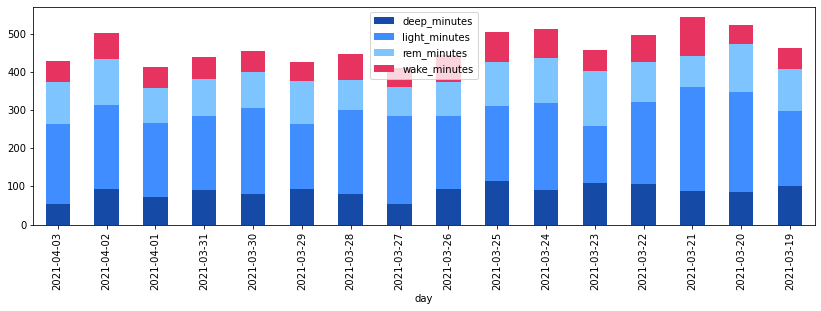

In [272]:
#Plotting data
plt.rcParams["figure.figsize"]=14,4
sleep_df.set_index('day').plot(kind='bar', stacked=True, color=['#154BA6', '#3F8DFF', '#7EC4FF', '#E73360'])

<h2>Resting heart rate</h2>

In [273]:
header = {'Authorization': 'Bearer {}'.format(access_token)}

response = requests.get("https://api.fitbit.com/1/user/-/activities/heart/date/"+start_date+"/"+end_date+".json", headers=header).json()

In [274]:
all_resting_HR_list = []
for i in response['activities-heart']:
    try:
        resting_dict = { 'dateTime':i['dateTime'], "resting_HR":i['value']['restingHeartRate']}
        all_resting_HR_list.append(resting_dict)
    except KeyError as e:
        print("No data for the given date", i['dateTime'])
    
    
resting_HR_df = pd.DataFrame(all_resting_HR_list)
resting_HR_df.dateTime = resting_HR_df.dateTime.apply(pd.Timestamp)
resting_HR_df.set_index("dateTime", inplace = True)

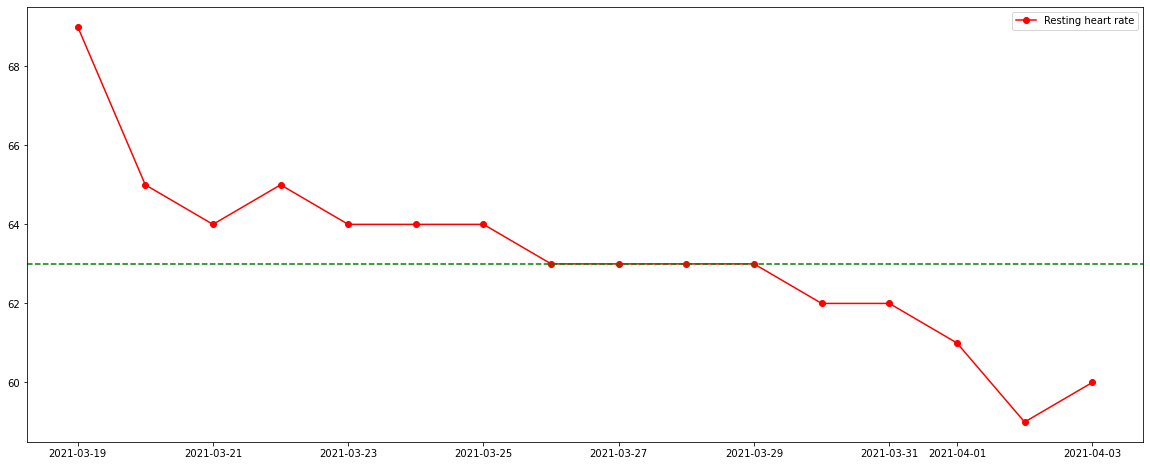

In [275]:
plt.rcParams["figure.figsize"]=20,8
#plt.ylim((60,75))
#plt.grid()
plt.plot(resting_HR_df,linestyle='-', marker='o', color='r', label = "Resting heart rate")
plt.legend()
plt.axhline(y = resting_HR_df.resting_HR.median(), color = 'g', linestyle = 'dashed')

In [276]:
start = pd.Timestamp(resting_HR_df.index[0])
end = pd.Timestamp(resting_HR_df.index[-1])
t = np.linspace(start.value, end.value, len(resting_HR_df.index))
x_ = pd.to_datetime(t)
y_ = resting_HR_df.resting_HR.to_list()

In [277]:
from scipy.interpolate import make_interp_spline

X_Y_Spline = make_interp_spline(x_,y_)

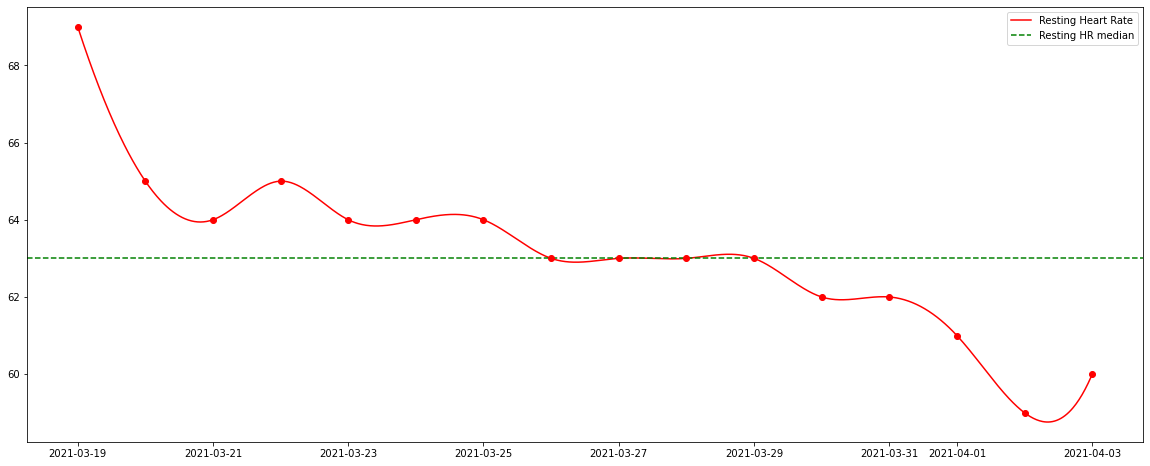

In [278]:
X_ = np.linspace(start.value, end.value, 1000)
Y_ = X_Y_Spline(X_)
 
# Plotting the Graph
X_ = pd.to_datetime(X_)
plt.plot(X_, Y_,  color = 'r', linestyle = '-', label = 'Resting Heart Rate')
plt.axhline(y = resting_HR_df.resting_HR.median(), color = 'g', linestyle = 'dashed', label = 'Resting HR median')
plt.legend()
plt.plot(resting_HR_df,linestyle='', marker='o', color='r')

<h2>Activity minutes</h2>

In [279]:
header = {'Authorization': 'Bearer {}'.format(access_token)}

response = requests.get("https://api.fitbit.com/1/user/-/activities/tracker/minutesSedentary/date/"+start_date+"/"+end_date+".json", headers=header).json()

minutesSedentary_list = [int(i['value']) for i in response['activities-tracker-minutesSedentary']]

response = requests.get("https://api.fitbit.com/1/user/-/activities/tracker/minutesLightlyActive/date/"+start_date+"/"+end_date+".json", headers=header).json()

minutesLightlyActive_list = [int(i['value']) for i in response['activities-tracker-minutesLightlyActive']]

response = requests.get("https://api.fitbit.com/1/user/-/activities/tracker/minutesFairlyActive/date/"+start_date+"/"+end_date+".json", headers=header).json()

minutesFairlyActive_list = [int(i['value']) for i in response['activities-tracker-minutesFairlyActive']]

response = requests.get("https://api.fitbit.com/1/user/-/activities/tracker/minutesVeryActive/date/"+start_date+"/"+end_date+".json", headers=header).json()

minutesVeryActive_list = [int(i['value']) for i in response['activities-tracker-minutesVeryActive']]

datetime_list = [i['dateTime'] for i in response['activities-tracker-minutesVeryActive']]

<AxesSubplot:>

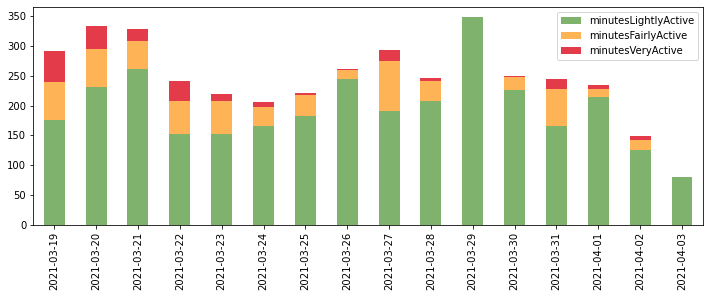

In [280]:
data_activity = {'minutesSedentary':minutesSedentary_list, 'minutesLightlyActive':minutesLightlyActive_list, 'minutesFairlyActive':minutesFairlyActive_list, 'minutesVeryActive':minutesVeryActive_list}

plt.rcParams["figure.figsize"]=12,4

pd.DataFrame(data_activity, index=datetime_list)[['minutesLightlyActive', 'minutesFairlyActive', 'minutesVeryActive']].plot(kind='bar', stacked=True, color=['#7EB26D', '#FFB357', '#E43B4A'])

<h2>Step count</h2>

In [281]:
header = {'Authorization': 'Bearer {}'.format(access_token)}

response = requests.get("https://api.fitbit.com/1/user/-/activities/steps/date/"+start_date+"/"+end_date+"/1min.json", headers=header).json()['activities-steps']


<AxesSubplot:xlabel='dateTime'>

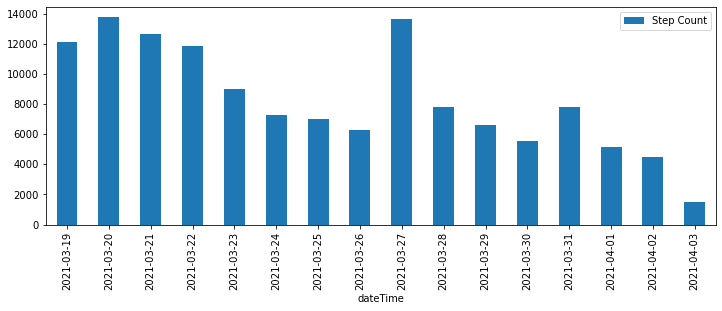

In [282]:
step_df = pd.DataFrame(response)
step_df['dateTime'] = pd.to_datetime(step_df['dateTime'].apply(pd.Timestamp)).dt.date
step_df['Step Count'] = step_df['value'].apply(int)
del step_df['value']
step_df.set_index('dateTime', inplace = True)
step_df.plot(kind = 'bar')

<h2>Distance</h2>

In [283]:
header = {'Authorization': 'Bearer {}'.format(access_token)}

response = requests.get("https://api.fitbit.com/1/user/-/activities/distance/date/"+start_date+"/"+end_date+"/1min.json", headers=header).json()['activities-distance']


<AxesSubplot:xlabel='dateTime'>

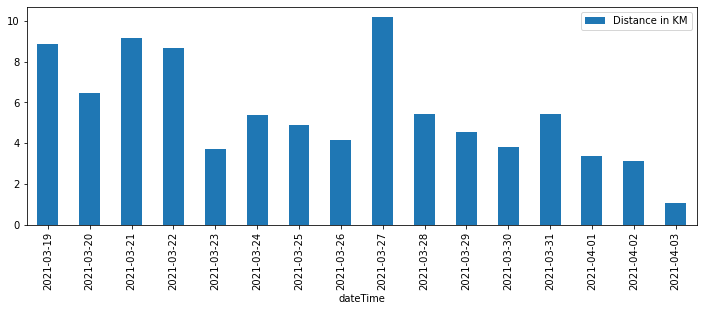

In [284]:
distance_df = pd.DataFrame(response)
distance_df['dateTime'] = pd.to_datetime(distance_df['dateTime'].apply(pd.Timestamp)).dt.date
distance_df['Distance in KM'] = distance_df['value'].apply(float)
del distance_df['value']
distance_df.set_index('dateTime', inplace = True)
distance_df.plot(kind = 'bar')

<h2>Floor count</h2>

In [285]:
header = {'Authorization': 'Bearer {}'.format(access_token)}

response = requests.get("https://api.fitbit.com/1/user/-/activities/floors/date/"+start_date+"/"+end_date+"/1min.json", headers=header).json()['activities-floors']

<AxesSubplot:xlabel='dateTime'>

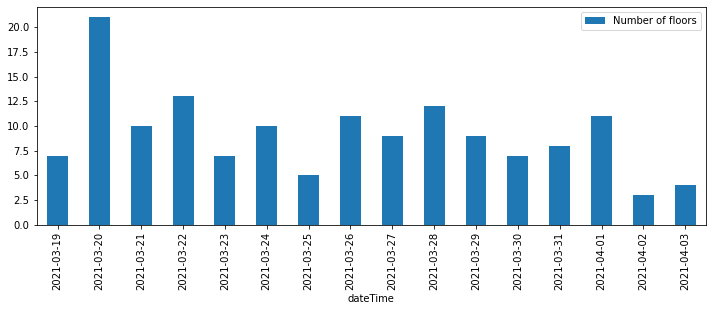

In [286]:
floor_df = pd.DataFrame(response)
floor_df['dateTime'] = pd.to_datetime(floor_df['dateTime'].apply(pd.Timestamp)).dt.date
floor_df['Number of floors'] = floor_df['value'].apply(int)
del floor_df['value']
floor_df.set_index('dateTime', inplace = True)
floor_df.plot(kind = 'bar')

<h2>Calories</h2>

In [287]:
header = {'Authorization': 'Bearer {}'.format(access_token)}

response = requests.get("https://api.fitbit.com/1/user/-/activities/calories/date/"+start_date+"/"+end_date+"/1min.json", headers=header).json()['activities-calories']

<AxesSubplot:xlabel='dateTime'>

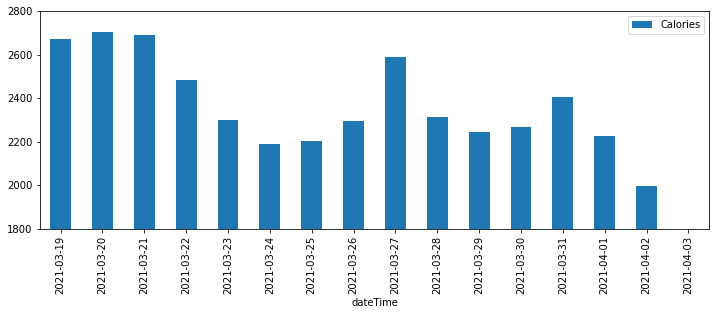

In [288]:
calorie_df = pd.DataFrame(response)
calorie_df['dateTime'] = pd.to_datetime(calorie_df['dateTime'].apply(pd.Timestamp)).dt.date
calorie_df['Calories'] = calorie_df['value'].apply(float)
del calorie_df['value']
calorie_df.set_index('dateTime', inplace = True)
calorie_df.plot(kind = 'bar', ylim = (1800,2800))

<h2>Elevation</h2>

In [289]:
header = {'Authorization': 'Bearer {}'.format(access_token)}

response = requests.get("https://api.fitbit.com/1/user/-/activities/elevation/date/"+start_date+"/"+end_date+"/1min.json", headers=header).json()['activities-elevation']

<AxesSubplot:xlabel='dateTime'>

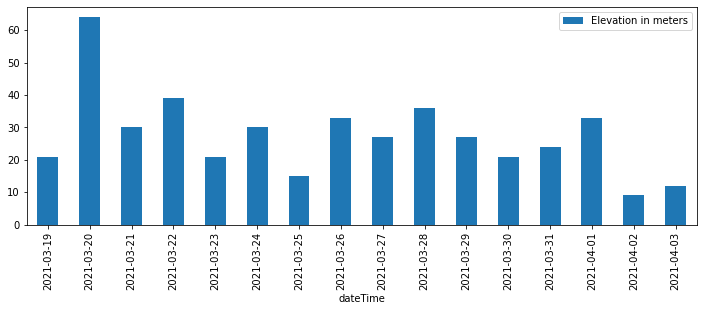

In [290]:
try:
    elevation_df = pd.DataFrame(response)
    elevation_df['dateTime'] = pd.to_datetime(elevation_df['dateTime'].apply(pd.Timestamp)).dt.date
    elevation_df['Elevation in meters'] = elevation_df['value'].apply(float)
    del elevation_df['value']
    elevation_df.set_index('dateTime', inplace = True)
except KeyError as e:
    print("No data for the given date")
elevation_df.plot(kind = 'bar')

<h2>Sleeping HR</h2>

In [294]:
#sleep_HR_date = "2021-03-19"
sleep_HR_date = str(datetime.datetime.date(datetime.datetime.now()))


In [295]:
splitted_date = sleep_HR_date.split('-')

year = int(splitted_date[0])
month = int(splitted_date[1])
day = int(splitted_date[2])

def parse(date):
    return "{}-{}-{}".format(date[6:], date[:2], date[3:5])

Previous_Date = datetime.datetime(year,month,day) - datetime.timedelta(days=1)
Previous_Date = parse(Previous_Date.strftime('%m/%d/%Y'))

In [296]:
header = {'Authorization': 'Bearer {}'.format(access_token)}

response = requests.get("https://api.fitbit.com/1/user/-/activities/heart/date/"+sleep_HR_date+"/1d/1min/time/00:00/08:00.json", headers=header).json()
response_2 = requests.get("https://api.fitbit.com/1/user/-/activities/heart/date/"+Previous_Date+"/1d/1min/time/22:30/23:59.json", headers=header).json()
prev_response = requests.get("https://api.fitbit.com/1/user/-/activities/heart/date/"+Previous_Date+"/1d.json", headers=header).json()
sleep_response = requests.get("https://api.fitbit.com/1/user/-/sleep/date/"+sleep_HR_date+".json", headers=header).json()

In [297]:
#Taking only mainsleep
for i in sleep_response['sleep']:
    if i['isMainSleep']:
        sleep_start_time = i['startTime']
        sleep_end_time = i['endTime']
    else:
        print("Nap skipped", i['startTime'],"and", i['endTime'] )

In [298]:
try:
    df = pd.DataFrame(response['activities-heart-intraday']['dataset'])
    df = df.set_index(pd.to_datetime(sleep_HR_date + ' ' + df['time'].astype(str)))
    df2 = pd.DataFrame(response_2['activities-heart-intraday']['dataset'])
    df2 = df2.set_index(pd.to_datetime(Previous_Date + ' ' + df2['time'].astype(str)))
    del df['time']
    del df2['time']
    df = df2.append(df)
except KeyError as e:
    print("No data for the given date", sleep_HR_date)


In [299]:
#range % determination
try:
    only_sleep_df = df[sleep_start_time:sleep_end_time]
    # % calculation
    above_resting = round((len(only_sleep_df[only_sleep_df["value"]>prev_response['activities-heart'][-1]['value']['restingHeartRate']])/len(only_sleep_df)) * 100)
    below_resting = 100 - above_resting
except KeyError as e:
    print("No data for the given date", sleep_HR_date)

#print("Above resting HR :",above_resting,"% \n\n Below resting HR :",below_resting,"%")

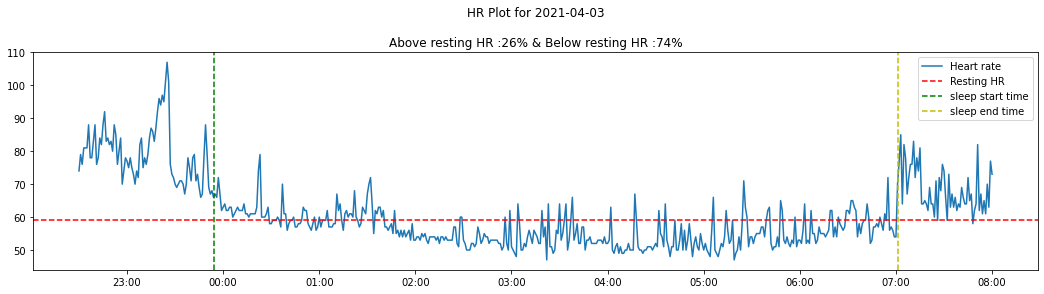

In [302]:
fig, ax = plt.subplots(1,1,figsize=(18,4))
#plt.ylim((45,100))
plt.plot(df,label = 'Heart rate')
plt.axhline(y = prev_response['activities-heart'][-1]['value']['restingHeartRate'], color = 'r', linestyle = 'dashed', label = 'Resting HR')
plt.axvline(x = datetime.datetime.strptime(sleep_start_time, '%Y-%m-%dT%H:%M:%S.%f'), color = 'g', linestyle = 'dashed', label = "sleep start time")
plt.axvline(x = datetime.datetime.strptime(sleep_end_time, '%Y-%m-%dT%H:%M:%S.%f'), color = 'y', linestyle = 'dashed', label = 'sleep end time')
plt.title("HR Plot for "+sleep_HR_date+"\n\n"+"Above resting HR :"+str(above_resting)+"% & Below resting HR :"+str(below_resting)+"%")
plt.legend()
formatter = dates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1)) 
#plt.grid()
plt.show()

<h2>Sleep timing</h2>

In [303]:
header = {'Authorization': 'Bearer {}'.format(access_token)}

response = requests.get("https://api.fitbit.com/1.2/user/-/sleep/date/"+start_date+"/"+end_date+".json", headers=header).json()


In [304]:
sleep_duration_list = []
for i in response['sleep']:
    sleep_duration_list.append({'date':i['dateOfSleep'], 'start_time':i['startTime'], 'end_time':i['endTime']})
    
df = pd.DataFrame(sleep_duration_list)
df = df.set_index('date')

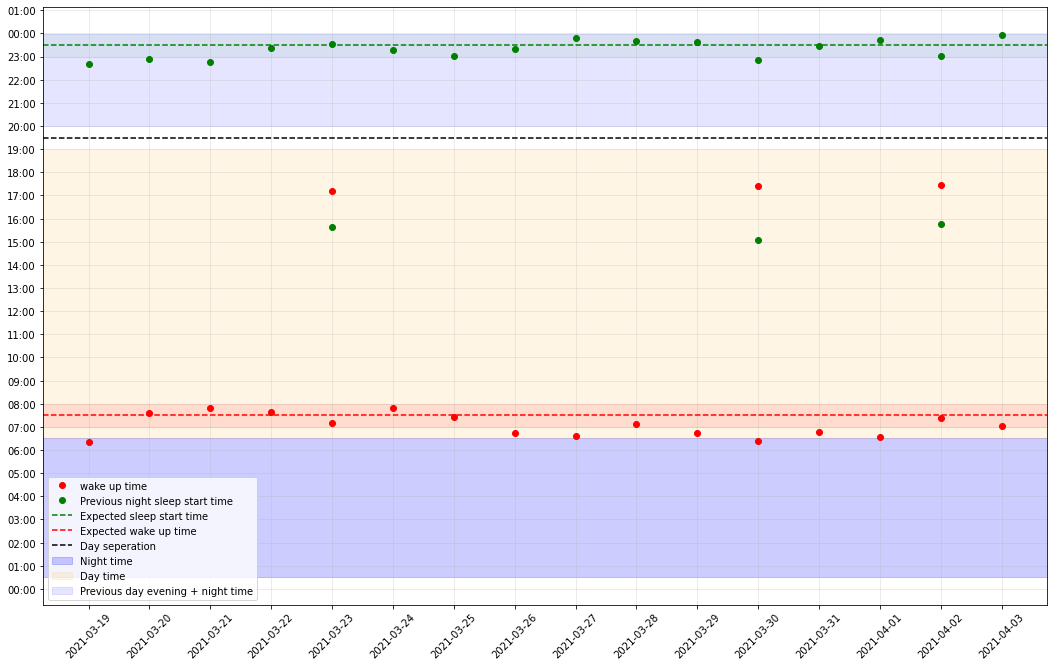

In [312]:
# Convert to matplotlib's internal date format.
x = mdates.datestr2num(df.index.to_series().to_list())


fig, ax = plt.subplots(1,1,figsize=(18,11))

y_ = mdates.datestr2num(['01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00', '06:00:00'])
x_ = mdates.datestr2num(['2021-03-25']*6)

ax.plot(x_, y_, 'wo', alpha  = 0)

y2 = mdates.datestr2num(df.end_time.apply(str).str.slice(11,19).to_list())
ax.plot(x, y2, 'ro', label = "wake up time")


ax.yaxis_date()
ax.xaxis_date()

formatter = dates.DateFormatter('%H:%M')
ax.yaxis.set_major_formatter(formatter)

y = mdates.datestr2num(df.start_time.apply(str).str.slice(11,19).to_list())
ax.plot(x, y, 'go', label = "Previous night sleep start time")


ax.yaxis_date()

ax.axhspan(mdates.datestr2num("00:30"), mdates.datestr2num("06:30"), alpha=0.2, color='blue', label = 'Night time')
ax.axhspan(mdates.datestr2num("06:30"), mdates.datestr2num("19:00"), alpha=0.1, color='orange', label = 'Day time')
ax.axhspan(mdates.datestr2num("20:00"), mdates.datestr2num("23:59"), alpha=0.1, color='blue', label = 'Previous day evening + night time')
ax.axhline(y = mdates.datestr2num("23:30:00"), color = 'g', linestyle = 'dashed', label = 'Expected sleep start time')
ax.axhline(y = mdates.datestr2num("07:30:00"), color = 'r', linestyle = 'dashed', label = 'Expected wake up time')
ax.axhline(y = mdates.datestr2num("19:30:00"), color = 'black', linestyle = 'dashed', label = 'Day seperation')
ax.axhspan(mdates.datestr2num("07:00"), mdates.datestr2num("08:00"), alpha=0.1, color='red')
ax.axhspan(mdates.datestr2num("23:00"), mdates.datestr2num("23:59"), alpha=0.05, color='green')

ax.xaxis.set_tick_params(rotation=45)
# Optional. Just rotates x-ticklabels in this case.
#fig.autofmt_xdate()
ax.grid(alpha = 0.3)
#plt.ylim(mdates.datestr2num('22:00'), mdates.datestr2num('9:00'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1)) 
plt.gca().yaxis.set_major_locator(mdates.HourLocator(interval=1)) 
plt.legend()
#plt.gca().invert_yaxis()
plt.show()